In [1]:
# Import necessary libraries
import transformers
import torch
import datasets
import pandas as pd
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoTokenizer, pipeline, Trainer, TrainingArguments, AutoModel, DataCollatorWithPadding
from datasets import load_dataset, concatenate_datasets, Dataset, load_from_disk

c:\Users\katha\anaconda3\envs\llm_torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load reviews for different categories from McAuley Labs Amazon dataset 
# Due to time and memory constraints, only one category was chosen
reviews = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Appliances")

Generating full split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [3]:
# Load meta data for the category
meta = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_Appliances")

Generating full split: 0 examples [00:00, ? examples/s]

In [23]:
# Print the dataset_dict to view its structure
print(reviews)
print(meta)

DatasetDict({
    full: Dataset({
        features: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase'],
        num_rows: 2128605
    })
})
DatasetDict({
    full: Dataset({
        features: ['main_category', 'title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images', 'videos', 'store', 'categories', 'details', 'parent_asin', 'bought_together', 'subtitle', 'author'],
        num_rows: 94327
    })
})


In [26]:
# Convert to pandas dataframe
reviews_df = reviews["full"].to_pandas()
meta_df = meta["full"].to_pandas()

In [27]:
# Preview reviews dataset
print(reviews_df.head())

   rating              title  \
0     5.0         Work great   
1     5.0  excellent product   
2     5.0    Happy customer!   
3     5.0      Amazing value   
4     5.0        Dryer parts   

                                                text images        asin  \
0              work great. use a new one every month     []  B01N0TQ0OH   
1                            Little on the thin side     []  B07DD2DMXB   
2                   Quick delivery, fixed the issue!     []  B082W3Z9YK   
3  I wasn't sure whether these were worth it or n...     []  B078W2BJY8   
4  Easy to install got the product expected to re...     []  B08C9LPCQV   

  parent_asin                       user_id      timestamp  helpful_vote  \
0  B01N0TQ0OH  AGKHLEW2SOWHNMFQIJGBECAF7INQ  1519317108692             0   
1  B07DD37QPZ  AHWWLSPCJMALVHDDVSUGICL6RUCA  1664746863446             0   
2  B082W3Z9YK  AHZIJGKEWRTAEOZ673G5B3SNXEGQ  1607225435363             0   
3  B078W2BJY8  AFGUPTDFAWOHHL4LZDV27ERDNOYQ  1534104

In [28]:
# Preview meta dataset
print(meta_df.head())

              main_category  \
0   Industrial & Scientific   
1  Tools & Home Improvement   
2  Tools & Home Improvement   
3  Tools & Home Improvement   
4  Tools & Home Improvement   

                                               title  average_rating  \
0  ROVSUN Ice Maker Machine Countertop, Make 44lb...             3.7   
1  HANSGO Egg Holder for Refrigerator, Deviled Eg...             4.2   
2  Clothes Dryer Drum Slide, General Electric, Ho...             3.5   
3  154567702 Dishwasher Lower Wash Arm Assembly f...             4.5   
4                        Whirlpool W10918546 Igniter             3.8   

   rating_number                                           features  \
0             61  [【Quick Ice Making】This countertop ice machine...   
1             75  [Plastic, Practical Kitchen Storage - Our egg ...   
2             18                                                 []   
3             26  [MODEL NUMBER:154567702 Dishwasher Lower Wash ...   
4             12         

In [31]:
# View column names of both datasets
print(f"Reviews columns: {reviews_df.columns}")
print(f"Meta columns: {meta_df.columns}")

Reviews columns: Index(['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase'],
      dtype='object')
Meta columns: Index(['main_category', 'title', 'average_rating', 'rating_number', 'features',
       'description', 'price', 'images', 'videos', 'store', 'categories',
       'details', 'parent_asin', 'bought_together', 'subtitle', 'author'],
      dtype='object')


In [29]:
# Remove all columns that won't be needed in any of the models, to make dataset smaller

# Drop columns from reviews data
reviews_cut = reviews_df.drop (columns = [
    "timestamp", 
    "helpful_vote",
    "images", 
    "asin", 
    "verified_purchase",
    "user_id"
    ])

# Drop columns from meta data
meta_cut = meta_df.drop (columns = [
    "images", 
    "videos", 
    "store",  
    "author"
    ])

In [32]:
# View column names of both datasets after dropping
print(f"Reviews columns: {reviews_cut.columns}")
print(f"Meta columns: {meta_cut.columns}")

Reviews columns: Index(['rating', 'title', 'text', 'parent_asin'], dtype='object')
Meta columns: Index(['main_category', 'title', 'average_rating', 'rating_number', 'features',
       'description', 'price', 'categories', 'details', 'parent_asin',
       'bought_together', 'subtitle'],
      dtype='object')


In [33]:
# Save dataframes to pickle files
reviews_cut.to_pickle("./Saved datasets/reviews.pkl")
meta_cut.to_pickle("./Saved datasets/meta.pkl")

In [16]:
# Load meta data from the pickle file after restarting machine
reviews_df = pd.read_pickle("./Saved datasets/reviews.pkl")
metad_df = pd.read_pickle("./Saved datasets/meta.pkl")

In [4]:
# Get the number of columns and rows for reviews dataframe
# Meta data not needed for sentiment analysis
print(f"Shape reviews: {reviews_df.shape}")

Shape reviews: (2128605, 4)


In [6]:
# View final column names of dataset
print(f"Reviews columns: {reviews_df.columns}")

Reviews columns: Index(['rating', 'title', 'text', 'parent_asin'], dtype='object')


In [7]:
# Check for missing values
print(reviews_df.isnull().sum())
print(reviews_df.isna().sum())

rating         0
title          0
text           0
parent_asin    0
dtype: int64
rating         0
title          0
text           0
parent_asin    0
dtype: int64


In [17]:
# Rename final version of reviews data
reviews_clean = reviews_df

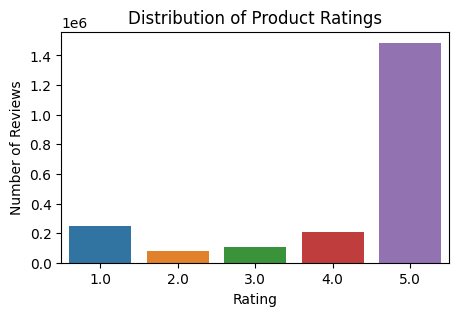

In [9]:
# Show distirbution between product ratings

# Calculate the frequency of each rating
rating_counts = reviews_clean["rating"].value_counts().sort_index()

# Visualize the distribution using Seaborn
plt.figure(figsize=(5, 3))
sns.barplot(x=rating_counts.index, y=rating_counts.values)
plt.title("Distribution of Product Ratings")
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.show()

In [10]:
# Select 5 random reviews from each rating and inspect the text
samples = reviews_clean.groupby("rating").apply(lambda x: x.sample(min(5, len(x)))).reset_index(drop=True)
print(samples[["rating", "text"]])

    rating                                               text
0      1.0  The item came in an envelope so it was dinged ...
1      1.0  Screen is not completely attached to the plast...
2      1.0  I reuse pods all the time and didn’t have this...
3      1.0  Product is terrible! Cheap plastic and broke w...
4      1.0  I bought this in October of 2020 and it broke ...
5      2.0       Wasn't big enough for my stove but it's cute
6      2.0  This is fairly flimsy basket that didn’t easil...
7      2.0                             Broke after 3 days use
8      2.0  I thought I was paying for a full set because ...
9      2.0  This is advertised as a Genuine Whirlpool part...
10     3.0  Initial Review:<br />Was having a problem with...
11     3.0                                Nice for the price.
12     3.0  Bought these filters so as not to fill up the ...
13     3.0  Product arrived the other day and my main issu...
14     3.0  Los accesorios se pelan son de plástico y no s...
15     4

/tmp/ipykernel_64/636525482.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  samples = reviews_clean.groupby("rating").apply(lambda x: x.sample(min(5, len(x)))).reset_index(drop=True)


In [18]:
# Use ratings as an approximation for labels (1-2 stars = neg, 3 stars = neut, 4-5 stars = pos)

# Define a function to classify ratings
def classify_rating(rating):
    if rating >= 4:
        return "positive"
    elif rating == 3:
        return "neutral"
    else:
        return "negative"

# Apply the function to create a new "sentiment" column
reviews_clean["sentiment"] = reviews_clean["rating"].apply(classify_rating)

# Display the data with the new column
print(reviews_clean.head())



   rating              title  \
0     5.0         Work great   
1     5.0  excellent product   
2     5.0    Happy customer!   
3     5.0      Amazing value   
4     5.0        Dryer parts   

                                                text parent_asin sentiment  
0              work great. use a new one every month  B01N0TQ0OH  positive  
1                            Little on the thin side  B07DD37QPZ  positive  
2                   Quick delivery, fixed the issue!  B082W3Z9YK  positive  
3  I wasn't sure whether these were worth it or n...  B078W2BJY8  positive  
4  Easy to install got the product expected to re...  B08C9LPCQV  positive  


In [19]:
# Combine "title" and "text" columns into a "combined_text" column
reviews_clean["combined_text"] = reviews_clean.apply(lambda row: f"{row['title']} {row['text']}", axis=1)

In [20]:
# Inspect new dataframe
print(reviews_clean.head())

   rating              title  \
0     5.0         Work great   
1     5.0  excellent product   
2     5.0    Happy customer!   
3     5.0      Amazing value   
4     5.0        Dryer parts   

                                                text parent_asin sentiment  \
0              work great. use a new one every month  B01N0TQ0OH  positive   
1                            Little on the thin side  B07DD37QPZ  positive   
2                   Quick delivery, fixed the issue!  B082W3Z9YK  positive   
3  I wasn't sure whether these were worth it or n...  B078W2BJY8  positive   
4  Easy to install got the product expected to re...  B08C9LPCQV  positive   

                                       combined_text  
0   Work great work great. use a new one every month  
1          excellent product Little on the thin side  
2   Happy customer! Quick delivery, fixed the issue!  
3  Amazing value I wasn't sure whether these were...  
4  Dryer parts Easy to install got the product ex...  


In [21]:
# Model expects input with sequence length = 512
# Reviews have to be truncated

def truncate_by_characters(text, max_chars=512):
    return text[:max_chars]

reviews_clean['truncated'] = reviews_clean['combined_text'].apply(truncate_by_characters)

print(reviews_clean.head())

   rating              title  \
0     5.0         Work great   
1     5.0  excellent product   
2     5.0    Happy customer!   
3     5.0      Amazing value   
4     5.0        Dryer parts   

                                                text parent_asin sentiment  \
0              work great. use a new one every month  B01N0TQ0OH  positive   
1                            Little on the thin side  B07DD37QPZ  positive   
2                   Quick delivery, fixed the issue!  B082W3Z9YK  positive   
3  I wasn't sure whether these were worth it or n...  B078W2BJY8  positive   
4  Easy to install got the product expected to re...  B08C9LPCQV  positive   

                                       combined_text  \
0   Work great work great. use a new one every month   
1          excellent product Little on the thin side   
2   Happy customer! Quick delivery, fixed the issue!   
3  Amazing value I wasn't sure whether these were...   
4  Dryer parts Easy to install got the product ex...   

 

In [22]:
# Load DistilBert model - tokenisation is handled internally
model_name = "lxyuan/distilbert-base-multilingual-cased-sentiments-student" 
model = AutoModel.from_pretrained(model_name)

In [23]:
# Check for GPU availability
print("Is CUDA available?", torch.cuda.is_available())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Is CUDA available? False


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [25]:
# Model cannot easily be retrained due to being student-teacher model 
# Set up the pipeline using the model card's example
distilled_student_sentiment_classifier = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student",
    top_k=1,
)

# Use the pipeline
result = distilled_student_sentiment_classifier("This is a great product!")
print(result)

[[{'label': 'positive', 'score': 0.9937844276428223}]]


In [26]:
# Function to get the predicted label from the model's output
def get_predicted_label(review):
    prediction_output = distilled_student_sentiment_classifier(review)[0][0]
    predicted_label = prediction_output['label']
    return predicted_label

In [24]:
# Uncomment if running on GPU
#torch.cuda.empty_cache() 

In [3]:
# Setting up testing checkpoints to save predictions in batches
chunk_size = 5000  # Define your batch size
checkpoint_file = './Model outputs/sentiment_checkpoint.csv'

In [ ]:
# Function to save checkpoint
def save_checkpoint(df, filepath):
    df.to_csv(filepath, index=False)

# Check if there's already a checkpoint to load
try:
    checkpoint_df = pd.read_csv(checkpoint_file)
    start_index = checkpoint_df.shape[0]
    processed_reviews = checkpoint_df
except FileNotFoundError:
    start_index = 0
    processed_reviews = pd.DataFrame()

# Process each chunk
for start in range(start_index, len(reviews_clean), chunk_size):
    chunk = reviews_clean.iloc[start:start + chunk_size]
    chunk['predicted_label'] = chunk['truncated'].apply(get_predicted_label)
    
    processed_reviews = pd.concat([processed_reviews, chunk])
    
    # Save the current state as a checkpoint
    save_checkpoint(processed_reviews, checkpoint_file)

print("Processing completed. Final results saved.")

C:\Users\katha\AppData\Local\Temp\ipykernel_24444\1650988120.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['predicted_label'] = chunk['truncated'].apply(get_predicted_label)
C:\Users\katha\AppData\Local\Temp\ipykernel_24444\1650988120.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['predicted_label'] = chunk['truncated'].apply(get_predicted_label)
C:\Users\katha\AppData\Local\Temp\ipykernel_24444\1650988120.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [4]:
# Load from csv
processed_reviews = pd.read_csv(checkpoint_file)

# Display the first few rows to verify the content
print(processed_reviews.head())

   rating              title  \
0     5.0         Work great   
1     5.0  excellent product   
2     5.0    Happy customer!   
3     5.0      Amazing value   
4     5.0        Dryer parts   

                                                text parent_asin sentiment  \
0              work great. use a new one every month  B01N0TQ0OH  positive   
1                            Little on the thin side  B07DD37QPZ  positive   
2                   Quick delivery, fixed the issue!  B082W3Z9YK  positive   
3  I wasn't sure whether these were worth it or n...  B078W2BJY8  positive   
4  Easy to install got the product expected to re...  B08C9LPCQV  positive   

                                       combined_text  \
0   Work great work great. use a new one every month   
1          excellent product Little on the thin side   
2   Happy customer! Quick delivery, fixed the issue!   
3  Amazing value I wasn't sure whether these were...   
4  Dryer parts Easy to install got the product ex...   

 

In [5]:
# Calculate accuracy
accuracy = accuracy_score(processed_reviews['sentiment'], processed_reviews['predicted_label'])
print(f"Accuracy: {accuracy}")

Accuracy: 0.8026112539018184


In [9]:
# Inspect examples where true != predicted value
mismatches = processed_reviews[processed_reviews['predicted_label'] != processed_reviews['sentiment']]

# Count total mismatches
total_mismatches = mismatches.shape[0]

# Print the total number of mismatches
print(f"Total number of mismatches: {total_mismatches}")

Total number of mismatches: 92388


In [10]:
# Sample 10 random mismatches
random_samples = mismatches.sample(n=10, random_state=42) 

# Inspect the samples
print(random_samples[['truncated', 'sentiment', 'predicted_label']])

                                                truncated sentiment  \
362623                It does what it is suppose to Stove  positive   
454789  Coffee snob approved I got a Nespresso vertuo ...  positive   
100047  Replacement Our old one was getting difficult ...  positive   
286197  Can't beat it for the price! The price of thes...  positive   
10511   Waste of money I FINALLY FOUND THE MESH COFFEE...   neutral   
157822  right filter I like to change my filter more o...  positive   
40504   What else can be said It works. Only problem i...  positive   
408189  No idea why this isn’t as good as the last Fla...  positive   
247834  Floating filter, but it can be hacked! I’m a c...   neutral   
213283  Got it for a single server Hamilton beach duo ...  negative   

       predicted_label  
362623        negative  
454789        negative  
100047        negative  
286197         neutral  
10511         positive  
157822        negative  
40504         negative  
408189        nega

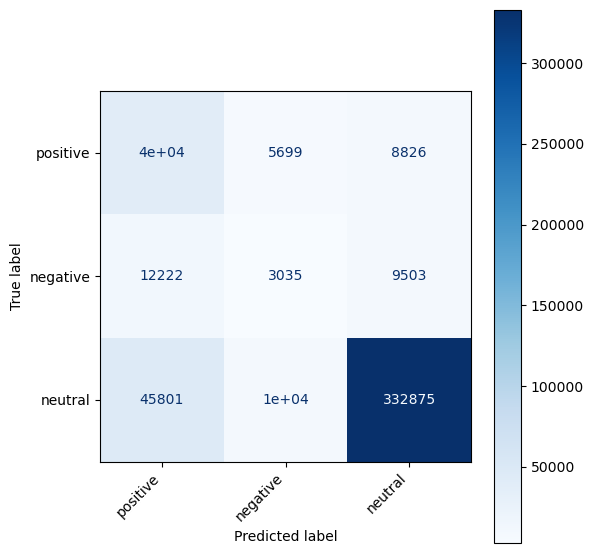

In [8]:
# Print confusion matrix
category_names = ["positive", "negative", "neutral"]

true_labels = processed_reviews['sentiment']
predicted_labels = processed_reviews['predicted_label']

# Step 2: Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Step 3: Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Step 4: Customize the plot
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)

# Set up the tick labels if you have specific category names
ax.set_xticklabels(category_names, rotation=45, ha='right')
ax.set_yticklabels(category_names)

plt.tight_layout()
plt.show()